# Config

In [95]:
#VERSION = 'focal_loss-161120200048'
#VERSION = 'release_focal_loss'
VERSION = 'final'
OVERWRITE_CHECKPOINT = False    
RECOVER_PAST_TRAINNING = True
TRAIN = False
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys, os
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 64
if RunningInCOLAB:
    BATCH_SIZE = 64

FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 30
GAMMA = 0.9
N_EPOCHS = 6
MODEL_ARCH = ['rsp-swin-t', 'rsp-resnet-50', 'swin_t_IMAGENET', 'resnet50_IMAGENET']

MODEL = 'rsp-swin-t'
#MODEL = 'rsp-resnet-50'


weights_models = {'rsp-swin-t': 'rsp-swin-t-ckpt.pth', 'swin_t_IMAGENET': 'IMAGENET1K_V1',
                      'rsp-resnet-50' : 'rsp-resnet-50-ckpt.pth', 'resnet50_IMAGENET':'' }

weights_filename = weights_models[MODEL]

config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": weights_filename}
      

# Set Environment

In [96]:
if RunningInCOLAB:
    from google.colab import drive, files, runtime

    drive.mount('/content/drive', force_remount=True)
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    %clear
    checkpoint_path_dir = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/content/planet/"
    experiment_results = f'/content/drive/MyDrive/Colab-Notebooks/results/{MODEL}/'
    %mkdir -p ${results}

else:
    home = os.environ['HOME']
    dataset_dir = home + "/UFMG/Thesis/datasets/planet"
    checkpoint_path_dir = home +'/UFMG/Thesis/Experiments/checkpoints/'
    experiment_results = home + f'/UFMG/Thesis/Experiments/results/{MODEL}/'

results_path = checkpoint_path_dir + f"train_results_{MODEL}_{VERSION}.pkl"
checkpoint_path = checkpoint_path_dir + f"{MODEL}_{VERSION}.pth"
weights_path = checkpoint_path_dir + f"{weights_filename}"          


In [97]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo opencv-python timm yacs seaborn kaleido
    %clear

In [98]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


# Libs

In [99]:
from collections import Counter
from copy import copy, deepcopy
from glob import glob
from matplotlib import pyplot as plt
from PIL import Image
from plotly import graph_objects as go
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, precision_recall_fscore_support, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from time import time
from torch import nn, Tensor
from torch.autograd import Variable
from torch.optim import AdamW, Adam
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torchvision import transforms, models
from tqdm.notebook import tqdm
import cv2
import dill as pickle
import gc
import numpy as np  # Torch wrapper for Numpy
import os
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import random
import seaborn as sns
import threading
import timm
import torch
import torch.optim as optim

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cpu


In [100]:
def clear_cache():
    if RunningInCOLAB:
        torch.cuda.empty_cache()
    gc.collect()

In [101]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1001)

# EDA

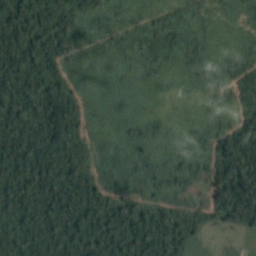

In [102]:
display(Image.open(path_train+'/train_333.jpg').convert("RGB"))

In [103]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)

(40479, 2)


In [104]:
label_list = []
for tag_str in df_class.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
# Histogram of label instances
#df_class[label_list].sum().sort_values().plot.bar()      

# Add onehot features for every label
for label in label_list:
    df_class[label] = df_class['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
df_class.head()

image_name                                       tags  haze  primary  \
0    train_0                               haze primary     1        1   
1    train_1            agriculture clear primary water     0        1   
2    train_2                              clear primary     0        1   
3    train_3                              clear primary     0        1   
4    train_4  agriculture clear habitation primary road     0        1   

   agriculture  clear  water  habitation  road  cultivation  slash_burn  \
0            0      0      0           0     0            0           0   
1            1      1      1           0     0            0           0   
2            0      1      0           0     0            0           0   
3            0      1      0           0     0            0           0   
4            1      1      0           1     1            0           0   

   cloudy  partly_cloudy  conventional_mine  bare_ground  artisinal_mine  \
0       0              0                  0            0               0   
1       0              0                  0            0               0   
2       0              0                  0            0               0   
3       0              0                  0            0               0   
4       0              0                  0            0               0   

   blooming  selective_logging  blow_down  
0         0                  0          0  
1         0                  0          0  
2         0                  0          0  
3         0                  0          0  
4         0                  0          0

In [105]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
title = 'Class distribution'
fig.update_layout(title="Tags distribution", width=600, height=400)
fig.show()
fig.savefig(experiment_results+title+".jpg")

AttributeError: 'Figure' object has no attribute 'savefig'

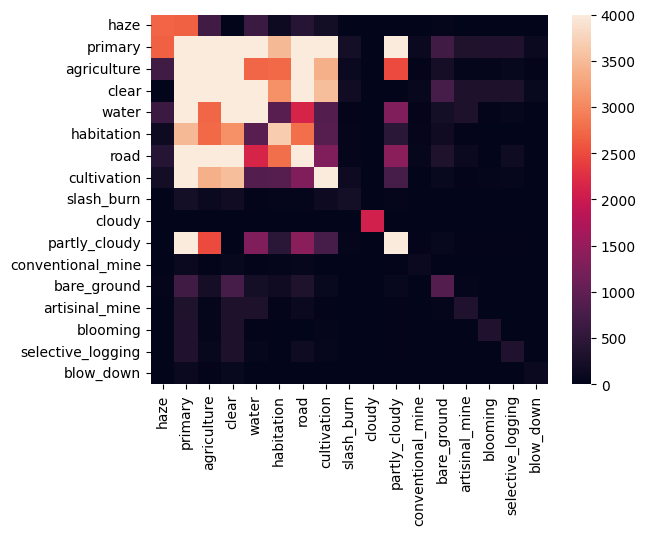

In [ ]:
def make_cooccurence_matrix(labels):
    numeric_df = df_class[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    title = 'Co-occurrence matrix'
    fig = sns.heatmap(c_matrix, vmax=4000)
    fig.savefig(experiment_results+title+".jpg")
    return c_matrix
    
# Compute the co-ocurrence matrix
c_matrix = make_cooccurence_matrix(label_list)

In [ ]:
RARE_CLASSES = ["bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"]
CLIMATE_CLASSES = ["clear", "partly_cloudly", "haze", "cloudy"]

## Train-Test split 80%-20%

In [ ]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1431% (694)
val bare_ground: 2.0751% (168)

train selective_logging: 0.8399% (272)
val selective_logging: 0.8399% (68)

train artisinal_mine: 0.8152% (264)
val artisinal_mine: 0.9264% (75)

train blooming: 0.8461% (274)
val blooming: 0.7164% (58)

train slash_burn: 0.5373% (174)
val slash_burn: 0.4323% (35)

train blow_down: 0.2501% (81)
val blow_down: 0.2100% (17)

train conventional_mine: 0.2378% (77)
val conventional_mine: 0.2841% (23)



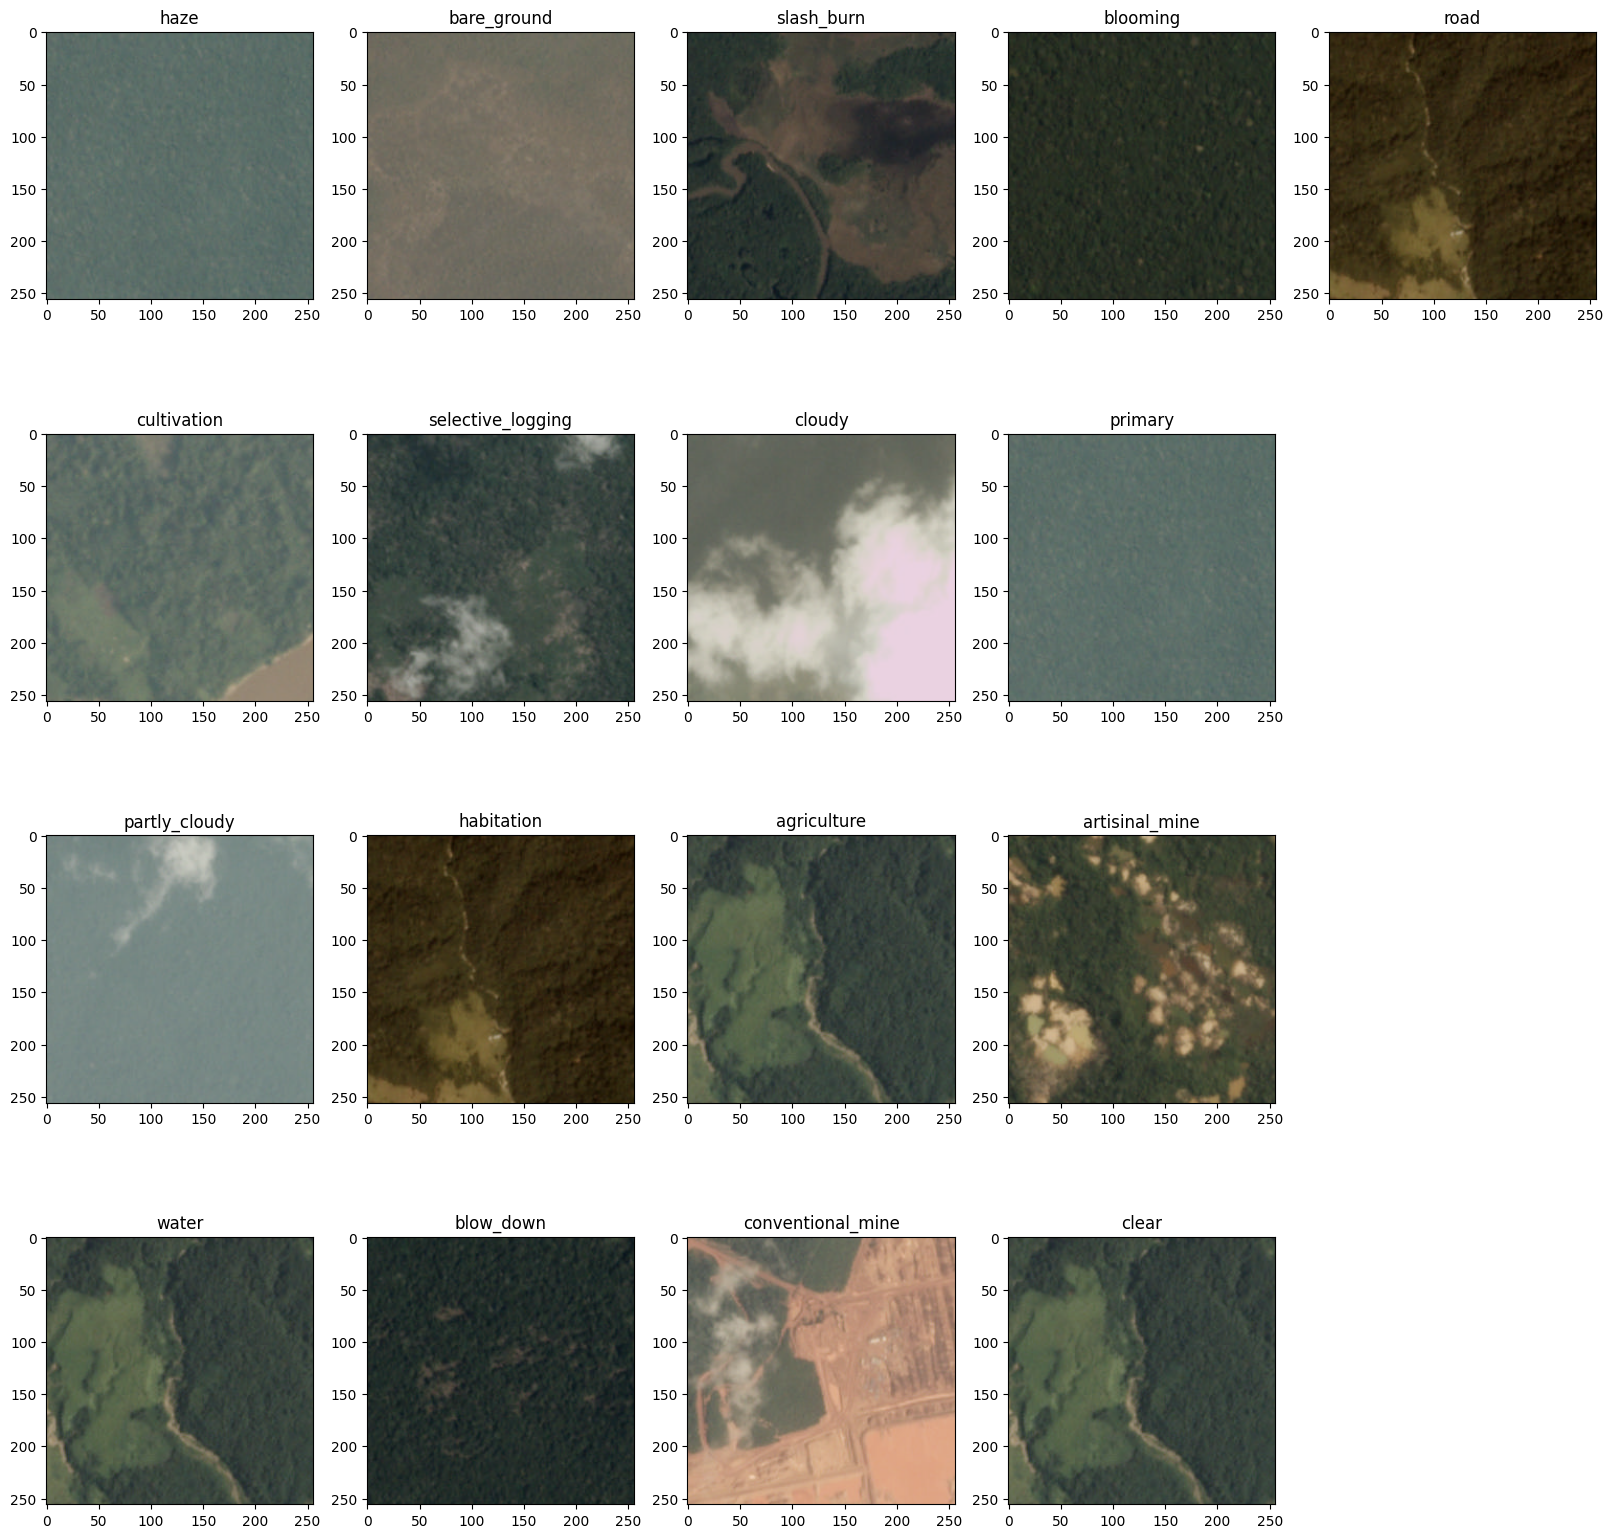

In [ ]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()
title = 'Class Sampling'
plt.savefig(experiment_results+title+".jpg")

In [ ]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [ ]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [ ]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

/home/vektor/.local/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



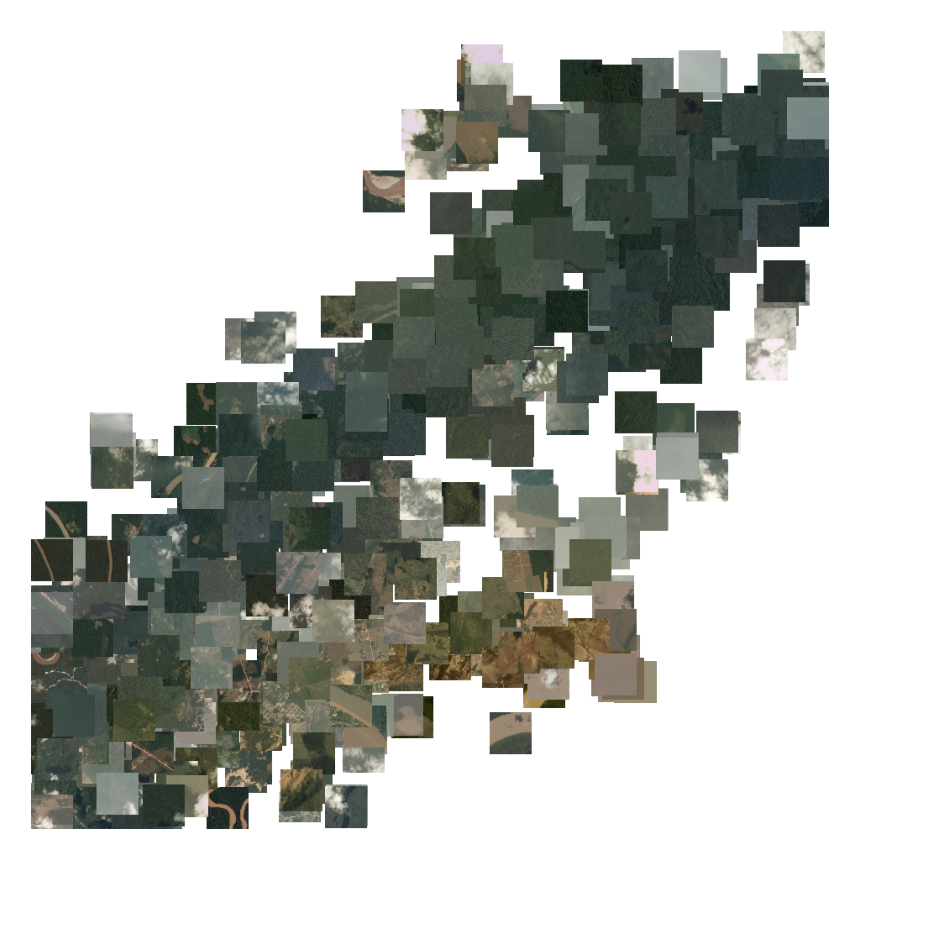

In [109]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=0,
    )
    X_embedded = tsne.fit_transform(X_train_sample)

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 * offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.axis("off")
    title = 'TSNE Clustering'
    plt.savefig(experiment_results+title+".png")
    return plt.imshow(img_tsne)

tsne_analysis()


# Dataset loader

In [ ]:
# create image augmentations
transform_train = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], # Imagenet normalization
        )                                                          # TODO: Normalize from the current dataset
])

transform_val = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225],
        )
])

In [ ]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [ ]:
def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True

    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=2,
        pin_memory=True,
        num_workers=2,
        drop_last=True
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train

In [ ]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)
classes = encoder.classes_
classes = list(classes)
def unitest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_val))
  print(imgs.shape, labels.shape)

#unitest_loader()

### Utils

In [ ]:
def load_checkpoint(filename):
    try:
        checkpoint = torch.load(filename, map_location=torch.device(device))
        print(checkpoint.keys())
        epoch = checkpoint['epoch']
        model_state = checkpoint['model']
        optimizer_state = checkpoint['optimizer']
        lr_scheduler_state = checkpoint['lr_scheduler']
        max_accuracy = checkpoint['max_accuracy']
        epoch = checkpoint['epoch']
        #config = checkpoint['config']
        return checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy
    except:
        print("Not able to load checkpoint ",filename)


def load_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        score = results['score']
        loss = results['loss']
        y_epochs = results['y']
        Y_thresh = results['Y_thresh']
        configs = results['config']
        epochs = results['epoch']
        max_accuracy = results['max_accuracy']

        return results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy

    except Exception as e:
        print("Not able to load results")
        print(e)  


def remove_file(path):
    if OVERWRITE_CHECKPOINT:
        try:
            os.remove(path)
            print(f"File {path} removed")
            return
        except Exception as e:
            print(e) 
    print(f"Not able to remove {path}")  

def save_overwrite_checkpoints(checkpoint, file):
    remove_file(file)
    torch.save(checkpoint, file)
    print(f"File {file} updated")


def save_overwrite_results(results, file):
    remove_file(file)
    pickle.dump(results, open(file, "wb+"))    
    print(f"File {file} updated")

def print_arch():
  print([module for module in model.modules() if not isinstance(module, nn.Sequential)])
    
def print_weights():
    kl = list()
    #unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
    unfreeze_param = ["head", "layers.3.blocks.1.mlp, layers.3.downsample.norm"]
    unfreeze_param = ["layers.3.blocks.1."]
    #unfreeze_param = ["head"]
    for k, v in model.state_dict().items():
        #v.requires_grad = False
        print(f"{k} requires grad {v.float().requires_grad}")
        for parameter in unfreeze_param:
            if parameter in k:
                freeze=False
                v=v.float()
                print(k,v)
                #v.requires_grad = True 
                print(f"unfreeze {k}")
                break
            freeze=True

        if freeze:
            #v.requires_grad = freeze
            kl.append(k)
            #print( k)  


# Model

## Loading pre-trained weights/checkpoints

In [ ]:
if RECOVER_PAST_TRAINNING:
    checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)
    results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
    print("recover_training")
else:
    if MODEL == 'resnet50_IMAGENET':
        model = models.resnet.resnet50(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    elif MODEL == 'swin_t_IMAGENET':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    else:
        checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(weights_path)
    results = {}

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])
recover_training


In [ ]:
def build_model_resnet_50(model_state):
    #https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

    model = models.resnet50()
    model.fc = nn.Sequential(
      nn.Linear(2048, 17), # 512 for resnet18 or 2048 for resnet 50
      nn.Sigmoid()
    )     

    if RECOVER_PAST_TRAINNING:
        info = model.load_state_dict(model_state, strict=True)
        return model.to(device)

    del model_state['fc.weight']
    del model_state['fc.bias']

    info = model.load_state_dict(model_state, strict=False)

    #for param in model.parameters():
    #    param.require_grad = False

    return model.to(device)


if MODEL == 'rsp-resnet-50':
    model = build_model_resnet_50(model_state)
    clear_cache()

In [ ]:
def build_model_swan_t(model_state):
    num_classes = 17
    swin_embed_dim = 768

    model = timm.models.swin_tiny_patch4_window7_224()
    model.head = nn.Linear(swin_embed_dim, num_classes)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())

    if RECOVER_PAST_TRAINNING:
        info = model.load_state_dict(model_state, strict=True)
        clear_cache()
        return model.to(device)

    state_dict = model_state

    # assuming that the head layer has 768 neurons, otherwise change it
    model.head = nn.Linear(swin_embed_dim, num_classes)
    #torch.nn.Sequential(model, torch.nn.Sigmoid())

    model = model.to(device)
    state_dict = model.state_dict()

    # delete relative_position_index since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete relative_coords_table since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete attn_mask since we always re-init it
    attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in attn_mask_keys:
        del state_dict[k]

    state_dict = model_state

    del state_dict['head.weight']
    del state_dict['head.bias']
    torch.nn.init.constant_(model.head.bias, 0.)
    torch.nn.init.constant_(model.head.weight, 0.)

    info = model.load_state_dict(state_dict, strict=False)
    model.head = nn.Linear(swin_embed_dim, num_classes)
    print(info)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())
    clear_cache()

    return model.to(device)


if MODEL == 'rsp-swin-t' :
    model = build_model_swan_t(model_state)



# Train setup

In [ ]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss.to(device)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, cooldown=2, factor=0.5, verbose=True, patience=10)
early_stopper = EarlyStopper(patience=2)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCELoss(weight=sample_weights)  # Binary Cross Entropy
#loss_fn = nn.BCELoss()  # Binary Cross Entropy
loss_fn = FocalLoss()
sample_weights

tensor([2.2826e+00, 1.2166e+02, 4.5661e+01, 1.1719e+02, 3.9879e+02, 4.2562e-01,
        1.8241e+01, 4.1956e+02, 8.0785e+00, 1.0082e+01, 1.4104e+01, 4.5450e+00,
        8.0009e-02, 4.0183e+00, 1.1806e+02, 1.8511e+02, 4.5111e+00],
       dtype=torch.float64)

### Batch fit/validate

In [ ]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    clear_cache()
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
    clear_cache()

    
#unit_test_batch_train()

In [ ]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))
    lr = np.zeros((N_EPOCHS,train_baches_epoch))
    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss, lr
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

505
tensor(0.)


In [ ]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
#eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


# Train

In [ ]:
def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results, checkpoint):
    train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

    y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
    epoch_start = 0
    if results and RECOVER_PAST_TRAINNING:
        train_results = deepcopy(results)
        epoch_start = checkpoint['epoch']
        best_score_val = train_results["score_val"]
        lr_scheduler = checkpoint['lr_scheduler']
        
    Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
    best_loss_val, best_score_val = torch.inf, 0
    Y_thresh_val = 0.2
    batch_loss = torch.inf
    for epoch in range(epoch_start, N_EPOCHS):

        for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
            Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
            loss["train"][epoch][idx] = batch_loss
            y_epoch["train"]["pred"][epoch][idx] = Y_hat
            y_epoch["train"]["label"][epoch][idx] = Y
            lr[epoch][idx] = optimizer.param_groups[0]['lr']
            if idx > 0 and idx % LR_STEP_SIZE == 0:
                avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
                it_score = eval_score(Y,Y_hat,Y_thresh_val)
                print(f'Train Loss: {avg_loss} score:{it_score}')
                lr_scheduler.step(metrics=avg_loss)
            #break

        for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss["val"][epoch][idx] = batch_loss
            y_epoch["val"]["pred"][epoch][idx] = Y_hat
            y_epoch["val"]["label"][epoch][idx] = Y
            #break
        

        score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                          y_epoch["train"]["pred"][epoch], Y_thresh_val)
        score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                        y_epoch["val"]["pred"][epoch], Y_thresh_val)

        avg_loss_train = loss["train"][epoch].mean()
        avg_loss_val = loss["val"][epoch].mean()

        best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
        best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val


        print(
            f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
            f"val loss: {avg_loss_val}"
            f" -- train fbeta_score: {score['train'][epoch]}, "
            f"val fbeta_score: {score['val'][epoch]}"
        )

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss_val,
            'max_accuracy': best_score_val,
            'best_loss_val': best_loss_val,
            'lr_scheduler': lr_scheduler.state_dict(),
            'config': config
        }

        results = {
            "loss": loss,
            "score": score,
            "y": y_epoch,
            'epoch': epoch,
            'best_loss_val': best_loss_val,
            'max_accuracy': best_score_val,
            'config': config,
            'Y_thresh' : Y_thresh_val,
            'lr':lr
        }
        
        if best_score_val <= score['val'][epoch]:
            save_overwrite_checkpoints(checkpoint, checkpoint_path)
        save_overwrite_results(results, results_path)

        if early_stopper.early_stop(score['val'][epoch]):             
           pass
           #break

        #break

if TRAIN:
    clear_cache()
    train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler, results, checkpoint)


### Train progress swin_T

```
Train Loss: 0.018138839262387445 score:0.8221826194240758
Train Loss: 0.004311692010941765 score:0.8931733684288965
Train Loss: 0.0025587673824761185 score:0.8750584735763964
Train Loss: 0.0020364553934233563 score:0.9133056202528194
Train Loss: 0.0014429676042298876 score:0.8977309270476515
Train Loss: 0.0012385313748382032 score:0.8913551247332949
Train Loss: 0.0011896954796787713 score:0.928824672204942
Train Loss: 0.0011030063033103943 score:0.9145640553541963
Train Loss: 0.0010500807040971854 score:0.926912504154617
Train Loss: 0.0008647050558319015 score:0.912406173868601
Train Loss: 0.0008203246904867551 score:0.9259343236250406
Train Loss: 0.0008332744154388145 score:0.9425312279632132
Train Loss: 0.0007721466076139721 score:0.9388080920135148
Train Loss: 0.0008614471908884063 score:0.899869120596706
Train Loss: 0.0007518306013099068 score:0.9211733735370355
Train Loss: 0.0007137722540421471 score:0.9107380540587293
epoch: 0/6 -- train loss: 0.002363990807282222, val loss: 0.00016690112332269402 -- train fbeta_score: 0.8934548137119928, val fbeta_score: 0.9172460192905533 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth updated File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updatedTrain Loss: 0.0006086751790491924 score:0.9299164324519293
Train Loss: 0.0006059311281499122 score:0.9568855500999264
Train Loss: 0.0007061341231981773 score:0.913151717387582
Train Loss: 0.0006544797257858238 score:0.9148805548841288
Train Loss: 0.000685104165665595 score:0.9121910584344407
Train Loss: 0.000641485815116715 score:0.9095385734925663
Train Loss: 0.0006811552889449822 score:0.8995971812934371
Train Loss: 0.0006223109160219469 score:0.9236067515122979
Train Loss: 0.0005980219768037298 score:0.9358000684976788
Train Loss: 0.0005093096148019897 score:0.9328866540498374
Train Loss: 0.0005247804341882827 score:0.9138555265178545
Train Loss: 0.0007085001589955702 score:0.9147196749662532
Train Loss: 0.0005522854837416221 score:0.9174609645627206
Train Loss: 0.0006783421507157806 score:0.9172615527854499
Train Loss: 0.0006390631700220008 score:0.9349095389410558
Train Loss: 0.0006044770345925504 score:0.9236049555981731
epoch: 1/6 -- train loss: 0.0006211294200718587, val loss: 0.00013843721817916093 -- train fbeta_score: 0.923058319551804, val fbeta_score: 0.9236077913629067 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth updated File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updatedTrain Loss: 0.0004577605277224774 score:0.930288635784659
Train Loss: 0.0005036104642297892 score:0.9346921049223681
Train Loss: 0.00043736416104835486 score:0.9394796210053563
Train Loss: 0.0005101225021550612 score:0.9329959779964618
Train Loss: 0.0005573536050618596 score:0.9399030945905946
Train Loss: 0.0005461464700807307 score:0.9198580792675461
Train Loss: 0.0004870130524655143 score:0.9389260322744178
Train Loss: 0.000502414176157946 score:0.9155243691247124
Train Loss: 0.0005409096789193309 score:0.9188029001907678
Train Loss: 0.000519279909278867 score:0.9390015941006989
Train Loss: 0.0005504350345056023 score:0.9290658758224206
Train Loss: 0.0004907468002432236 score:0.945112591900038
Train Loss: 0.0004832514825994299 score:0.9411395948630203
Train Loss: 0.0005140994208857357 score:0.9239139945022299
Epoch 00046: reducing learning rate of group 0 to 5.0000e-05.
Train Loss: 0.00044823838576238845 score:0.9155227687608445
Train Loss: 0.00041173662541569363 score:0.9517735772985044
epoch: 2/6 -- train loss: 0.0004939267818561276, val loss: 0.0001181390787138244 -- train fbeta_score: 0.9279188934840908, val fbeta_score: 0.9280978033015921 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth updated File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updatedTrain Loss: 0.0003763853211797053 score:0.9261461175813923
Train Loss: 0.0003877294277058794 score:0.9389598003415665
Train Loss: 0.00039311578298257963 score:0.934316546978875
Train Loss: 0.0003417483981578581 score:0.9410310748722026
Train Loss: 0.00038712033663966484 score:0.9399782335793765
Train Loss: 0.0004023127976031373 score:0.9272083401056792
Train Loss: 0.00037018850871977667 score:0.9450978481975405
Train Loss: 0.0003836601381115014 score:0.9410063188785616
Train Loss: 0.0004157666065317068 score:0.9526249535731586
Train Loss: 0.00037833210315570354 score:0.9451478559238633
Train Loss: 0.0003405283608909456 score:0.9118511324821951
Train Loss: 0.0003898673591808596 score:0.9599608931962997
Train Loss: 0.0003292043212211631 score:0.9222261103659272
Train Loss: 0.0003328354477191404 score:0.9424874792526847
Train Loss: 0.00036987141591511785 score:0.9593770629731108
Train Loss: 0.00045176912587316284 score:0.954225814718018
epoch: 3/6 -- train loss: 0.0003789717468547192, val loss: 0.00012363851140137982 -- train fbeta_score: 0.934115320150895, val fbeta_score: 0.9262749777289219 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updatedTrain Loss: 0.0003068026604934505 score:0.933025413157355
Train Loss: 0.00033104037861302196 score:0.9357635237345715
Train Loss: 0.00029838793946715495 score:0.9501706571444624
Train Loss: 0.0003071618785109041 score:0.9412804637934665
Train Loss: 0.00034050940397015265 score:0.9304126249670319
Train Loss: 0.00035528275076367503 score:0.9575574112647833
Train Loss: 0.00038233721763038285 score:0.9244271322130887
Train Loss: 0.0003241014851336067 score:0.8950126157572883
Train Loss: 0.00041198175430538195 score:0.9382873839036336
Train Loss: 0.0003507220666975744 score:0.9377945622086247
Train Loss: 0.0003395512129270261 score:0.9395902441936933
Train Loss: 0.0003362147779684634 score:0.9451392169766841
Train Loss: 0.00039457662745506593 score:0.933995345082179
Train Loss: 0.00032447663280406905 score:0.9282381643232069
Epoch 00078: reducing learning rate of group 0 to 2.5000e-05.
Train Loss: 0.0003471715101641753 score:0.9321010488613739
Train Loss: 0.0003463971938359581 score:0.9434734111753206
epoch: 4/6 -- train loss: 0.00034119911584945507, val loss: 0.0001137468074033461 -- train fbeta_score: 0.9362451362813651, val fbeta_score: 0.9290556280102331 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-swin-t_final.pth updated File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updatedTrain Loss: 0.0002882318935477205 score:0.923750005960242
Train Loss: 0.00033464213817252687 score:0.9412865114253623
Train Loss: 0.0002625835742594885 score:0.9637715291955681
Train Loss: 0.0002627288786536684 score:0.9566599064306265
Train Loss: 0.000272874265295198 score:0.9443680223285487
Train Loss: 0.0002583104503555073 score:0.9213199209537564
Train Loss: 0.0003216732389597793 score:0.9327588165399198
Train Loss: 0.0002994136574993571 score:0.958560730661882
Train Loss: 0.0002467000306369887 score:0.9383676939057426
Train Loss: 0.0002794888512712092 score:0.9490584397372566
Train Loss: 0.00033364544182287286 score:0.9536031599889445
Train Loss: 0.0002895672656567542 score:0.9635418306435283
Train Loss: 0.00028221002256970915 score:0.9347101396468315
Train Loss: 0.00028599754389893687 score:0.9339043162932257
Train Loss: 0.00029007448545364183 score:0.9519018208180923
Train Loss: 0.0002600753291664014 score:0.941614847102678
epoch: 5/6 -- train loss: 0.00028855614941181054, val loss: 0.0001160585839303653 -- train fbeta_score: 0.9405480654096167, val fbeta_score: 0.9284363059443598 File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl removed File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-swin-t_final.pkl updated```

### Train Progress resnet

In [ ]:
if RunningInCOLAB:
    #files.download(results_path)
    #files.download(checkpoint_path)
    #!sleep 600
    runtime.unassign()

###

# Analysis

In [ ]:
results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
checkpoint, best_epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)

dict_keys(['epoch', 'model', 'optimizer', 'loss', 'max_accuracy', 'best_loss_val', 'lr_scheduler', 'config'])


## Training statistics

In [ ]:
def moving_average(series, window):
    y = np.zeros(len(series) - window)
    std = np.zeros(len(series) - window)
    confidence_interval = np.zeros(len(series) - window)
    for i in range(len(y)):
        y[i] = series[i:i+window].mean()
        std[i] = series[i:i+window].std()
        confidence_interval[i] = series[i:i+window].std()*1.96/np.sqrt(window)
    return y, confidence_interval

moving_average(loss['train'].flatten(), window=10)    

def confidence_interval(series):
    std = series.std(axis=1)
    return std * 1.96/np.sqrt(std.size)

#confidence_interval(loss['val'])

In [ ]:
filtered_loss, train_confidence_interval = moving_average(loss['train'].flatten(), window=BATCH_SIZE)

eps = 1e-4
train_lower_bound = filtered_loss - train_confidence_interval
train_lower_bound[train_lower_bound <= 0 ] = eps
val_confidence_interval = confidence_interval(loss['val'])
val_x_axis = np.arange(1,len(loss['train'].mean(axis=1))+1)*ds_train_size//BATCH_SIZE - BATCH_SIZE
fig = go.Figure([
    go.Scatter(
        name='Trainning Loss',
        x=np.arange(1,len(filtered_loss)+1),
        y= filtered_loss,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    ),
    go.Scatter(
        name='Upper Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y=filtered_loss + train_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower Bound',
        x=np.arange(1,len(filtered_loss)+1),
        y = train_lower_bound,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty',
        showlegend=False
    ),

    go.Scatter(
        name='Validation Loss',
        x=val_x_axis,
        y = loss['val'].mean(axis=1),
        marker=dict(color="#0F0"),
        line=dict(width=1),
        mode='lines',
        showlegend=True
    ),
    go.Scatter(
        name='Upper Bound',
        x=val_x_axis,
        y=loss['val'].mean(axis=1) + val_confidence_interval,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Validation Lower Bound',
        x=val_x_axis,
        y = loss['val'].mean(axis=1) - val_confidence_interval,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(88, 88, 88, 0.3)',
        fill='tonexty',
        showlegend=False
    )
    
])
title = 'Training Loss Per Minibatch'
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title='Training loss per minibatch',
    hovermode="x"
)
fig.update_yaxes(type="log")
#fig.update_xaxes(type="log")
fig.update_layout(width=500, height=500)
fig.write_image(experiment_results+title+".jpg")

In [ ]:
def eval_epoch_scores(Y_label_eval, Y_pred_eval, thresh):
    batches = Y_label_eval.shape[1]
    epochs = Y_label_eval.shape[0]
    batches_scores = np.zeros((epochs, batches))

    for epoch_idx in range(epochs):
        for batch_idx in range(batches):
            batches_scores[epoch_idx][batch_idx] = eval_score(Y_label_eval[epoch_idx][batch_idx],
                                                Y_pred_eval[epoch_idx][batch_idx], thresh)
    return batches_scores.mean(axis=1), confidence_interval(batches_scores)

#eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)                                             

In [ ]:
train_score, train_confidence = eval_epoch_scores(results['y']['train']["label"], results['y']['train']["pred"], 0.2)
val_score, val_confidence = eval_epoch_scores(results['y']['val']["label"], results['y']['val']["pred"], 0.2)

In [ ]:
fig = go.Figure([
        go.Scatter(
            x=list(range(train_score.size)),
            y=train_score,
            name="score_train",
            error_y_array=train_confidence
        ),
        go.Scatter(
            x=list(range(val_score.size)),
            y=val_score,
            name="score_val",
            error_y_array=val_confidence
        )
    ])
title = 'Training Loss Per Epoch'    
fig.update_layout(
    yaxis_title='Log Loss',
    xaxis_title='Mini-batch iteration',
    title=title,
    hovermode="x",
    width=500, height=500
)
fig.write_image(experiment_results+title+".jpg")



## Classifier evaluation

### Using validation set from best epoch

In [ ]:
Y_hat_val = results['y']['val']["pred"][-1].reshape(-1,FEATURES).numpy()
Y_val = results['y']['val']["label"][-1].reshape(-1,FEATURES).numpy()
Y_hat_val.shape

(8064, 17)

In [ ]:
pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
fig = go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
])
title = "Marginal Probabilities Per Class"
fig.update_layout(width=1000, height=500, title=title)
fig.write_image(experiment_results+title+".jpg")


In [ ]:
def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")
    return best_threshs

best_threshs = find_best_thresholds(Y_hat_val, Y_val)


  0%|          | 0/17 [00:00<?, ?it/s]

threshs: [0.23, 0.46, 0.18, 0.39, 0.25, 0.09, 0.09, 0.1, 0.22, 0.14, 0.19, 0.11, 0.15, 0.2, 0.33, 0.38, 0.2] -- best score: 0.9312765088620264


In [ ]:
def classify(probs):
    return (probs > best_threshs).astype(float)

def classify_class(probs, class_idx):
    return (probs[:, class_idx].ravel() > best_threshs[class_idx]).astype(float)
    
#classify(Y_hat_val)
#classify_class(y_pred, 7)

In [ ]:
def plot_score_per_tag(threshs):
    class_scores = {}
    classes = encoder.classes_
    for jdx in range(Y_val.shape[1]):
        y_val = Y_val[:, jdx].ravel()
        score = fbeta_score(y_val, classify_class(Y_hat_val, jdx), beta=2)
        class_scores[classes[jdx]] = round(score, 4)

    df_score = pd.DataFrame(dict(
        label=list(class_scores.keys()), score=list(class_scores.values()),
    )).sort_values("score", ascending=True)
    fig = px.bar(df_score, x="label", y="score", color="score")
    fig.update_layout(
        title='Score Per Class Using Optimal Thresholds',
        width=800, height=400
    )
    fig.show()
    fig.write_image(experiment_results+"Score Per Class Using Optimal Thresholds.jpg")

    
plot_score_per_tag(best_threshs)


In [ ]:
plot_idx = 0

def get_plot_coords():
    global plot_idx
    row = plot_idx // 4+1
    col = plot_idx % 4+1
    plot_idx +=1
    return col, row

fig = make_subplots(cols=5, rows=5)
for jdx in range(Y_val.shape[1]):
    if not classes[jdx] in RARE_CLASSES:
        #continue
        pass

    y_val = Y_val[:, jdx].ravel()
    y_hat_val_class = classify_class(Y_hat_val, jdx)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val_class).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col, row = get_plot_coords()

    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(width=800, height=1000, title="Confusion Matrices")
fig.show()
fig.write_image(experiment_results+"Confusion Matrices.jpg")


In [ ]:
y_true = results['y']['val']['label'][-1].reshape((-1,FEATURES)).numpy()
y_pred = results['y']['val']['pred'][-1].reshape((-1,FEATURES)).numpy()

fig1 = go.Figure()
fig1.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1, name='no_skill'
)

fig2 = go.Figure()
fig2.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=0
)

for i in range(y_true.shape[1]):
    y_true_class = y_true[:, i]
    y_pred_class = y_pred[:, i]

    if not classes[i] in RARE_CLASSES:
        continue


    precision, recall, fbeta, support = precision_recall_fscore_support(y_true_class, y_pred_class>0.2, average='binary')
    precision, recall, thresholds= precision_recall_curve(y_true_class, y_pred_class)
    name = f"{classes[i]} (fbeta={fbeta:.3f})"
    fig2.add_trace(go.Scatter(x=recall, y=precision, name=name, mode='lines'))

    fpr, tpr, _ = roc_curve(y_true_class, y_pred_class)
    auc_score = roc_auc_score(y_true_class, y_pred_class, average='macro')
    name = f"{classes[i]} (AUC={auc_score:.3f})"
    fig1.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))
    


fig1.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    title = 'ROC Curve'
)
fig1.show()
fig2.write_image(experiment_results+"ROC Curve.jpg")
fig2.update_layout(
    yaxis_title='Precision',
    xaxis_title='Recall',
    #yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500,
    title = 'PR Curve'
)
fig2.show()
fig2.write_image(experiment_results+"PR Curve.jpg")
